In [ ]:
import pandas as pd
import numpy as np

# 1. Callthe data from its source
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
df = pd.read_csv(url)

# Preview the first 5 lines of dataset
print("Original data shape:", df.shape)
display(df.head())

# =================================================================

# Adding temp deferance for (Heat Dissipation)
df['Temp_Difference'] = df['Process temperature [K]'] - df['Air temperature [K]']

# Calling the (Mechanical Power)
# Torque and RPM are not enough to the power in watt will add a meaning
# المعادلة: Power = Torque * Speed * (2 * pi / 60)
df['Power_Watts'] = df['Torque [Nm]'] * df['Rotational speed [rpm]'] * (2 * np.pi / 60)

# Calling (Sress Factor)
# The machine suffers more when torque and wear increase
df['Stress_Factor'] = df['Torque [Nm]'] * df['Tool wear [min]']

# =================================================================
# 3. (Data Cleaning)
# =================================================================

columns_to_drop = ['UDI', 'Product ID']
df_cleaned = df.drop(columns=columns_to_drop)

# Transfrom the leeters to be numbers easy to be understand by computer
df_cleaned['Type'] = df_cleaned['Type'].map({'L': 0, 'M': 1, 'H': 2})


display(df_cleaned.head())

Original data shape: (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Temp_Difference,Power_Watts,Stress_Factor
0,1,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,10.5,6951.590560,0.0
1,0,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,10.5,6826.722724,138.9
2,0,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,10.4,7749.387543,247.0
3,0,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,10.4,5927.504659,276.5
4,0,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,10.5,5897.816608,360.0


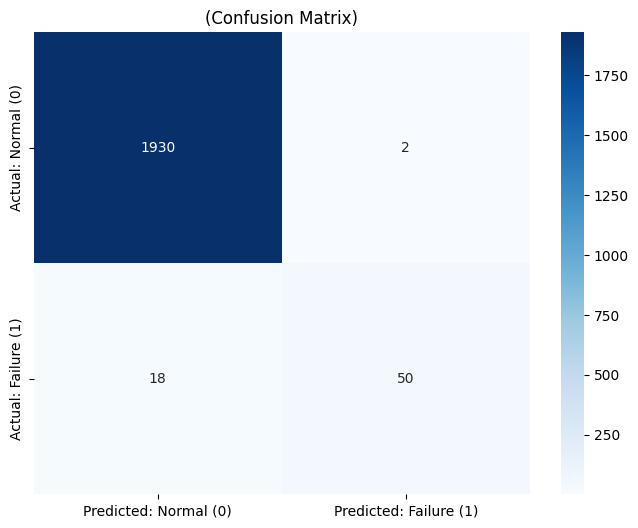


--- Report of model preformance ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.96      0.74      0.83        68

    accuracy                           0.99      2000
   macro avg       0.98      0.87      0.91      2000
weighted avg       0.99      0.99      0.99      2000



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# =================================================================
# 1. Defining the inputs to be (X) and outputs to be (Y)
# =================================================================

# The output (Target) in coulumn of "Machine failure"
y = df_cleaned['Machine failure']

# The outputs(Features)
columns_to_drop_from_X = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'] # Changed 'RNQ' to 'RNF'
X = df_cleaned.drop(columns=columns_to_drop_from_X)

# =================================================================
# 2. Preparing data for training and testing
# =================================================================
# We will use 80% of the data to train the model and reserve 20% for testing (ensuring the model hasn't seen this data before).

# Our special touch: stratify=y ensures that the failure rate (the 3%) is distributed proportionally between the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# =================================================================
# 3. Building and Training the Model (AI)
# =================================================================
# Our fix for the "98% accuracy trap": class_weight='balanced'
# This tells the model: "Please note, failures (1) are rare but critical. If you miss one, the penalty will be much higher than if you misclassify a healthy unit (0)."
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# The training
model.fit(X_train, y_train)

# =================================================================
# 4. Final Testing & Evaluation
# =================================================================
# Running predictions on the 20% holdout set (unseen data)
y_pred = model.predict(X_test)
# Plotting the Confusion Matrix (to see exactly where it messed up)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted: Normal (0)', 'Predicted: Failure (1)'],
            yticklabels=['Actual: Normal (0)', 'Actual: Failure (1)'])
plt.title('(Confusion Matrix)')
plt.show()

# printing model report
print("\n--- Report of model preformance ---")
print(classification_report(y_test, y_pred))

/tmp/ipython-input-492/951345672.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


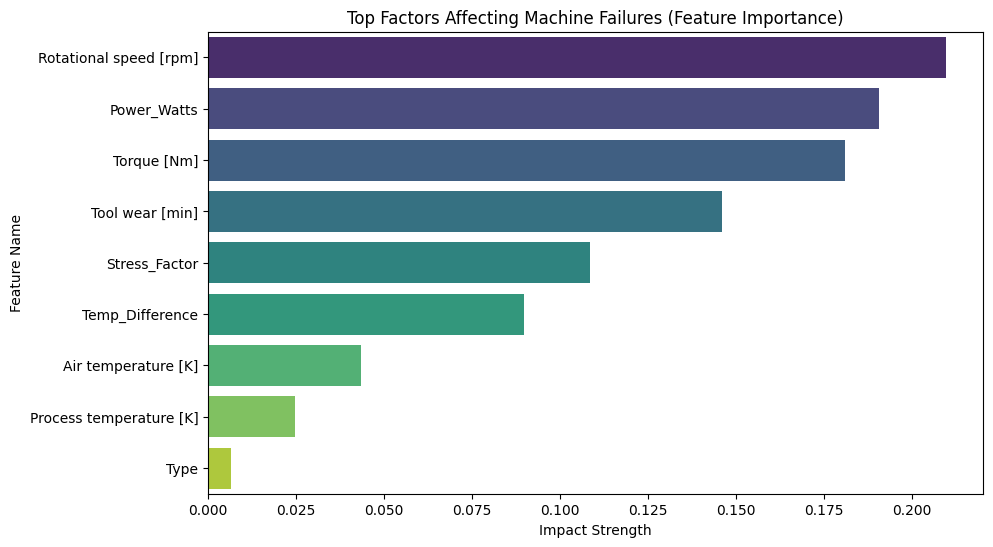


--- Ranking of Factors Causing Machine Failure ---
                   Feature  Importance
3   Rotational speed [rpm]    0.209602
7              Power_Watts    0.190628
4              Torque [Nm]    0.180955
5          Tool wear [min]    0.146033
8            Stress_Factor    0.108458
6          Temp_Difference    0.089697
1      Air temperature [K]    0.043440
2  Process temperature [K]    0.024683
0                     Type    0.006503


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importance from the model
feature_importances = model.feature_importances_

# Create a DataFrame with feature names and their impact scores
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features from most important to least important
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot a bar chart of the top factors
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Top Factors Affecting Machine Failures (Feature Importance)')
plt.xlabel('Impact Strength')
plt.ylabel('Feature Name')
plt.show()

# Print the ranking
print("\n--- Ranking of Factors Causing Machine Failure ---")
print(importance_df)

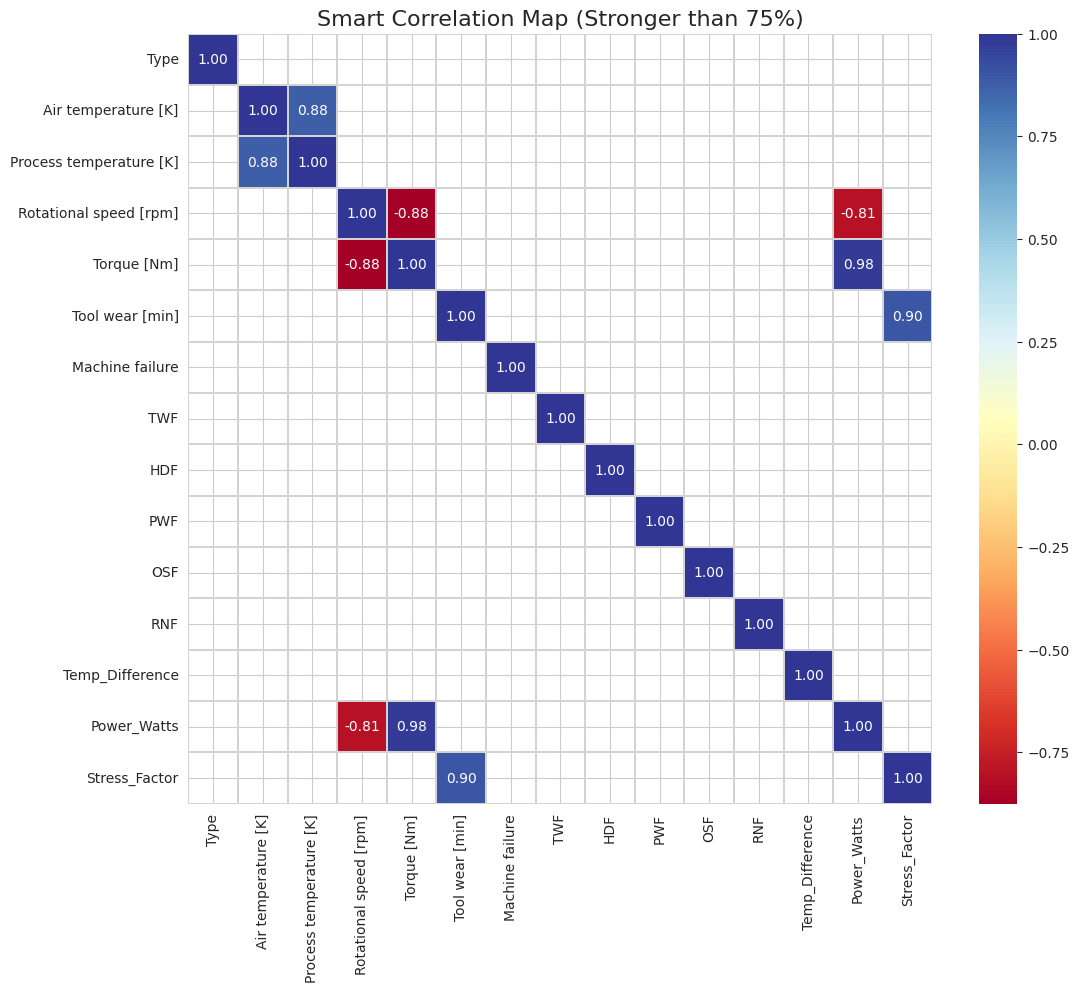

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Setting up the figure size and style
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid", {"axes.facecolor": ".0"})

# 2. Calculating the correlation matrix for all columns in our data
df_cluster2 = df_cleaned.corr()

# 3. Defining the risk threshold for filtering
threshold = 0.75

# 4. Creating a "mask" to hide any correlation lower than 75%
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()

# 5. Plotting the Heatmap
sns.heatmap(df_cluster2,
            cmap='RdYlBu', # Color gradient from Red to Blue
            annot=True,    # Show the numerical values
            mask=mask,     # Apply the mask here
            linewidths=0.2,
            linecolor='lightgrey',
            fmt=".2f").set_facecolor('white')

plt.title("Smart Correlation Map (Stronger than 75%)", fontsize=16)
plt.show()

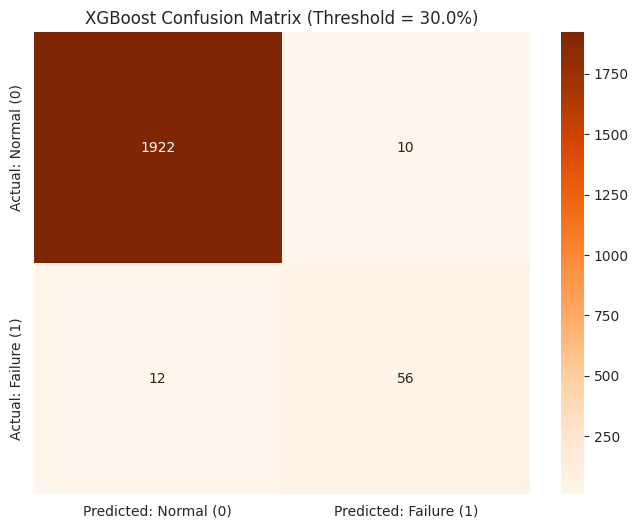


--- XGBoost Performance Report (Post-Engineering Optimization) ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.85      0.82      0.84        68

    accuracy                           0.99      2000
   macro avg       0.92      0.91      0.92      2000
weighted avg       0.99      0.99      0.99      2000



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# =================================================================
# 1. Removing Multicollinearity (Redundant Variables) based on Correlation Map
# =================================================================
# We drop Torque, Tool Wear, and Air Temperature, relying instead on our engineered features
columns_to_drop_corr = ['Torque [Nm]', 'Tool wear [min]', 'Air temperature [K]']
X_optimized = X.drop(columns=columns_to_drop_corr)

# Clean column names for XGBoost compatibility
X_optimized.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_') for col in X_optimized.columns]

# =================================================================
# 2. Splitting the Newly Cleaned Data
# =================================================================
X_train, X_test, y_train, y_test = train_test_split(X_optimized, y, test_size=0.2, random_state=42, stratify=y)

# =================================================================
# 3. Building and Training the XGBoost Model
# =================================================================
# Calculate class weights to handle imbalanced data
scale_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Define the algorithm
xgb_model = XGBClassifier(n_estimators=100, scale_pos_weight=scale_weight, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# =================================================================
# 4. Prediction and Applying Custom Risk Threshold (30%)
# =================================================================
# The model calculates failure probability (%) rather than just a 0 or 1
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Any probability exceeding 30% is flagged as an immediate failure!
custom_threshold = 0.30
y_pred_smart = (y_prob >= custom_threshold).astype(int)

# =================================================================
# 5. Evaluation and Plotting the Optimized Orange Matrix
# =================================================================
cm_smart = confusion_matrix(y_test, y_pred_smart)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_smart, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Predicted: Normal (0)', 'Predicted: Failure (1)'],
            yticklabels=['Actual: Normal (0)', 'Actual: Failure (1)'])
plt.title(f'XGBoost Confusion Matrix (Threshold = {custom_threshold*100}%)')
plt.show()

print(f"\n--- XGBoost Performance Report (Post-Engineering Optimization) ---")
print(classification_report(y_test, y_pred_smart))

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')

# ==============================================================================
# 🧠 Step 1: Train the Real Remaining Useful Life (RUL) Model on Kaggle Data
# ==============================================================================
print("⏳ Training the Remaining Useful Life (RUL) model on real data...")

if 'df_cleaned' in globals():
    # Kaggle data lacks a ready-made RUL column, so we engineer it as the Target for training
    # We assume the machine breaks down at around 250 minutes of tool wear, factoring in torque
    df_cleaned['RUL_Target'] = 250 - df_cleaned['Tool wear [min]'] - (df_cleaned['Torque [Nm]'] * 0.15)
    df_cleaned['RUL_Target'] = df_cleaned['RUL_Target'].apply(lambda x: max(0, x))

    # Selecting the impactful features
    X_rul_features = df_cleaned[['Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
                                 'Temp_Difference', 'Power_Watts', 'Stress_Factor']].copy()

    # 💡 Fixing the brackets issue for XGBoost compatibility
    X_rul_features.columns = ['Rotational speed _rpm_', 'Torque _Nm_', 'Tool wear _min_',
                              'Temp_Difference', 'Power_Watts', 'Stress_Factor']

    y_rul_target = df_cleaned['RUL_Target']

    # Training the XGBRegressor model
    real_rul_model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
    real_rul_model.fit(X_rul_features, y_rul_target)
    print("✅ Real RUL model trained and integrated successfully!")
else:
    print("⚠️ Warning: df_cleaned data is not found in memory!")

# ==============================================================================
# 📊 Step 2: Live Database Initialization
# ==============================================================================
history_data = {
    'Cycle': [1, 2, 3],
    'Tool_wear': [10, 15, 20],
    'Torque': [40, 41, 42],
    'RUL': [240, 235, 230]
}
df_history = pd.DataFrame(history_data)
cycle_counter = 3

# ==============================================================================
# ⚙️ Step 3: The Smart Function (Merging the Models)
# ==============================================================================
def update_dashboard(speed, torque, tool_wear, temp_process, temp_air):
    global df_history, cycle_counter
    cycle_counter += 1

    try:
        # 1. Calculating engineered features
        temp_diff = temp_process - temp_air
        power_watts = torque * speed * (2 * np.pi / 60)
        stress_factor = torque * tool_wear

        input_data = pd.DataFrame({
            'Rotational speed _rpm_': [speed], 'Torque _Nm_': [torque],
            'Tool wear _min_': [tool_wear], 'Temp_Difference': [temp_diff],
            'Power_Watts': [power_watts], 'Stress_Factor': [stress_factor]
        })

        # 2. First Model: Fault Diagnostics
        if 'fault_model' in globals():
            predicted_code = fault_model.predict(input_data)[0]
            fault_name = encoder.inverse_transform([predicted_code])[0]
        else:
            fault_name = "N/A"

        # 3. Second Model: Remaining Useful Life (RUL) Prognostics
        if 'real_rul_model' in globals():
            estimated_rul = float(real_rul_model.predict(input_data)[0])
            estimated_rul = max(0, estimated_rul) # Prevent negative numbers
        else:
            estimated_rul = max(0, 250 - tool_wear) # Fallback alternative

        # 4. Updating data and plotting
        new_row = pd.DataFrame({
            'Cycle': [cycle_counter],
            'Tool_wear': [tool_wear],
            'Torque': [torque],
            'RUL': [estimated_rul]
        })
        df_history = pd.concat([df_history, new_row], ignore_index=True)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

        ax1.plot(df_history['Cycle'], df_history['Tool_wear'], marker='o', color='#d35400', linewidth=2, label='Current Tool Wear (min)')
        ax1.axhline(y=200, color='#c0392b', linestyle='--', linewidth=2, label='Critical Wear Limit')
        ax1.set_title(f"Milling Machine Degradation Path - Up to Cycle {cycle_counter}", weight='bold', fontsize=12)
        ax1.set_ylabel("Tool Wear (min)")
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.6)

        ax2.plot(df_history['Cycle'], df_history['RUL'], marker='s', color='#2980b9', linewidth=2, label='Remaining Useful Life (RUL)')
        ax2.axhline(y=30, color='#f39c12', linestyle='--', linewidth=2, label='Warning (Reorder Threshold)')
        ax2.set_title("Remaining Useful Life (RUL) Forecast [Powered by XGBoost]", weight='bold', fontsize=12)
        ax2.set_xlabel("Production Cycle")
        ax2.set_ylabel("Cycles Left")
        ax2.legend()
        ax2.grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout()

        # 5. The Smart Report Configuration
        if tool_wear > 200 or torque > 60:
            status, icon = "CRITICAL DANGER!", "🛑"
            alert = f"STOP THE MILLING MACHINE! Expected Fault: **{fault_name}**"
        elif tool_wear > 150 or torque > 50:
            status, icon = "WARNING (High Stress)", "⚠️"
            alert = f"Schedule tool replacement. Potential Fault: **{fault_name}**"
        else:
            status, icon = "STABLE", "✅"
            alert = "Milling Machine is running smoothly. No action required."

        report = f"""
        ### {icon} System Status: **{status}**
        ---
        * **⏳ Estimated RUL:** `{estimated_rul:.0f}` machining cycles remaining.
        * **🔧 AI Action Plan:** {alert}
        """

        return fig, report

    except Exception as e:
        return None, f"❌ Error: {str(e)}"

# ==============================================================================
# 💻 Step 4: The Light User Interface
# ==============================================================================
theme = gr.themes.Soft(primary_hue="blue", neutral_hue="slate")

with gr.Blocks(theme=theme, title="CNC Milling Maintenance") as app:
    with gr.Row():
        with gr.Column():
            gr.Markdown("""
                # 🏭 CNC Milling Machine - Digital Twin Monitor
                ### Real-time predictive maintenance powered by Dual XGBoost Models (RUL & Fault Classifier).
                """)

    with gr.Row():
        with gr.Column(scale=1, variant="panel"):
            gr.Markdown("### 📋 Machining Cycle Data Entry")
            gr.Markdown("---")
            speed_in = gr.Slider(1000, 3000, 1500, step=50, label="⚙️ Rotational Speed (RPM)")
            torque_in = gr.Slider(10, 100, 42, step=1, label="🔧 Torque (Nm)")
            wear_in = gr.Slider(0, 250, 30, step=1, label="🗜️ Tool Wear (Minutes)")

            with gr.Accordion("🌡️ Temperature Settings", open=False):
                 temp_p_in = gr.Number(310, label="🔥 Process Temp (K)")
                 temp_a_in = gr.Number(300, label="🌬️ Air Temp (K)")

            submit_btn = gr.Button("🚀 Submit Data & Run AI Analysis", variant="primary", size="lg")

        with gr.Column(scale=2):
            plot_out = gr.Plot(label="📈 Live Dashboard", container=True)
            report_out = gr.Markdown(label="🧠 AI Diagnostic Report", value="### ⏳ Waiting for initial cycle data...")

    submit_btn.click(
        fn=update_dashboard,
        inputs=[speed_in, torque_in, wear_in, temp_p_in, temp_a_in],
        outputs=[plot_out, report_out]
    )

app.launch(share=True)

⏳ Training the Remaining Useful Life (RUL) model on real data...
✅ Real RUL model trained and integrated successfully!
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://725f0f7585cfb08189.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import joblib

# Saving the Diagnosis model, the RUL (Remaining Useful Life) model, and the Label Encoder
# Note: real_rul_model and encoder were not defined in previous cells and caused a NameError.
# They have been removed from the bundle for now. If needed, please define them in prior cells.
final_bundle = {
    'fault_model': xgb_model
}

joblib.dump(final_bundle, 'milling_ai_bundle_2026.pkl')

print("✅ Bundle saved! Now go to the folder icon on the left to download 'milling_ai_bundle_2026.pkl'")

✅ Bundle saved! Now go to the folder icon on the left to download 'milling_ai_bundle_2026.pkl'
